<a href="https://colab.research.google.com/github/Faisal-161/News_classification_GRU/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)

class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/MyDrive/data/data.csv'


## Connect with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the data from Drive

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/data.csv")
df

,headline,category,newspaper name
0,"হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই, কেন!",Amusement,Jugantor
1,এত দামি জুতা পরেন প্রিয়াঙ্কা!,Amusement,Jugantor
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,Amusement,Jugantor
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,Amusement,Jugantor
4,বিয়ের পর কোহলির জন্য যে ত্যাগ করলেন আনুশকা,Amusement,Jugantor
...,...,...,...
136806,অন্যরকম উদযাপন,national,Dainik Inqilab
136807,তিস্তাসহ অভিন্ন নদীর ন্যায্য হিস্যা দাবিতে বিক...,national,Dainik Inqilab
136808,রাজনীতি ছাড়তে চান,national,Dainik Inqilab
136809,বিএনপি নির্বাচনী ভীতিতে ভুগছে,national,Dainik Inqilab


## Plotting the Dataset Category Distribution

Total number of headlines: 136811


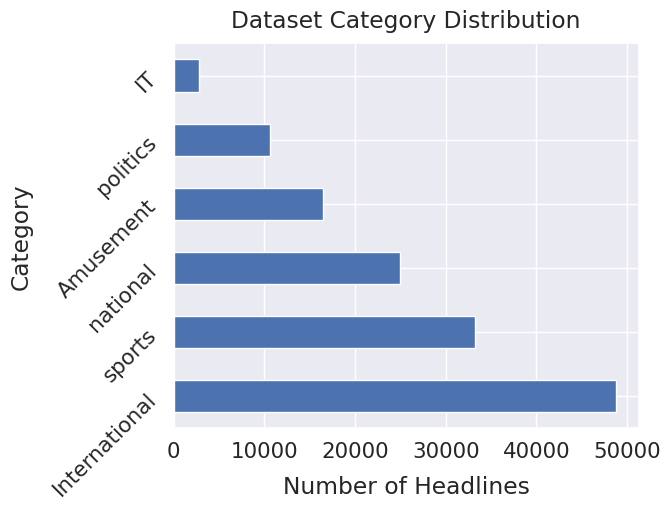

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/data.csv',encoding='utf-8')
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(6, 5))
plt.xlabel("Number of Headlines", labelpad=10)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Category Distribution", y=1.02);

## Showing the number of coulumns

In [ ]:
data.columns

Index(['headline', 'category', 'newspaper name'], dtype='object')

## Removing the unnecessary symbol using RegEx expression.

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
# Apply the function into the dataframe
data['cleaned'] = data['headline'].apply(cleaning_data)

# print some cleaned reviews from the dataset
sample_data = [3000,6000,9000,21000,31000,35000,41000,45000,50000,61000,65000,71000,76000,81000,100000]
for i in sample_data:
  print('Original: ',data.headline[i],'\nCleaned:',
           data.cleaned[i],'\n','Category:-- ',data.category[i],'\n')

Original:  ‘মামা সব মশার জামিন হয়ে গেছে’ 
Cleaned:  মামা সব মশার জামিন হয়ে গেছে  
 Category:--  Amusement 

Original:  মহাকাশে বঙ্গবন্ধু স্যাটেলাইট উৎক্ষেপণ সরাসরি দেখবেন যেভাবে 
Cleaned: মহাকাশে বঙ্গবন্ধু স্যাটেলাইট উৎক্ষেপণ সরাসরি দেখবেন যেভাবে 
 Category:--  IT 

Original:  খালাস চেয়ে খালেদা জিয়ার আপিল শুনানি ৮ আগস্ট পর্যন্ত মুলতবি 
Cleaned: খালাস চেয়ে খালেদা জিয়ার আপিল শুনানি ৮ আগস্ট পর্যন্ত মুলতবি 
 Category:--  politics 

Original:  প্রথম ফাইভজি চালু হল দ. কোরিয়ায় 
Cleaned: প্রথম ফাইভজি চালু হল দ  কোরিয়ায় 
 Category:--  International 

Original:  মেক্সিকো সীমান্তে সেনা পাঠাচ্ছেন ট্রাম্প 
Cleaned: মেক্সিকো সীমান্তে সেনা পাঠাচ্ছেন ট্রাম্প 
 Category:--  International 

Original:  সেরাটা দিতে পারলে সিরিজ জিতবে বাংলাদেশ: মাশরাফি 
Cleaned: সেরাটা দিতে পারলে সিরিজ জিতবে বাংলাদেশ  মাশরাফি 
 Category:--  sports 

Original:  রোহিতের আয় জানলে অবাক হবেন 
Cleaned: রোহিতের আয় জানলে অবাক হবেন 
 Category:--  sports 

Original:  কংগ্রেস সভাপতির পদ থেকে রাহুল গান্ধীর পদত্যাগ 
Cleaned: কংগ্রেস সভা

## Remove smaller headlines.

In [ ]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(data)-len(dataset)),
      "\nTotal Headlines:",len(dataset))

After Cleaning: 
Removed 4098 Small Headlines 
Total Headlines: 132713


## Showing number of total data by category, uniques word and most frequent words.

In [ ]:

def data_summary(dataset):


    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.category==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)


Class Name :  International
Number of Documents:47885
Number of Words:307354
Number of Unique Words:28710
Most Frequent Words:

নিহত	3398
না	2133
নিয়ে	1634
ট্রাম্প	1472
মার্কিন	1434
ও	1342
থেকে	1332
ভারতের	1212
যুক্তরাষ্ট্র	1208
ভারত	1192

Class Name :  sports
Number of Documents:30831
Number of Words:152852
Number of Unique Words:18581
Most Frequent Words:

বাংলাদেশ	1581
না	1122
জয়	883
বাংলাদেশের	873
শুরু	782
নিয়ে	689
সাকিব	672
ভারত	619
শেষ	603
দল	573

Class Name :  national
Number of Documents:24557
Number of Words:158042
Number of Unique Words:20710
Most Frequent Words:

না	1444
হবে	1292
ও	1215
প্রধানমন্ত্রী	1003
আজ	752
থেকে	617
কাদের	613
খালেদা	566
বিএনপি	557
নিয়ে	556

Class Name :  Amusement
Number of Documents:16067
Number of Words:98582
Number of Unique Words:16622
Most Frequent Words:

নতুন	1158
নিয়ে	1074
ও	1003
গান	683
ভিডিও	517
না	484
নাটক	469
খান	461
চলচ্চিত্র	416
আজ	412

Class Name :  politics
Number of Documents:10577
Number of Words:75657
Number of Unique Words:10398
Mos

## Plotting words by category

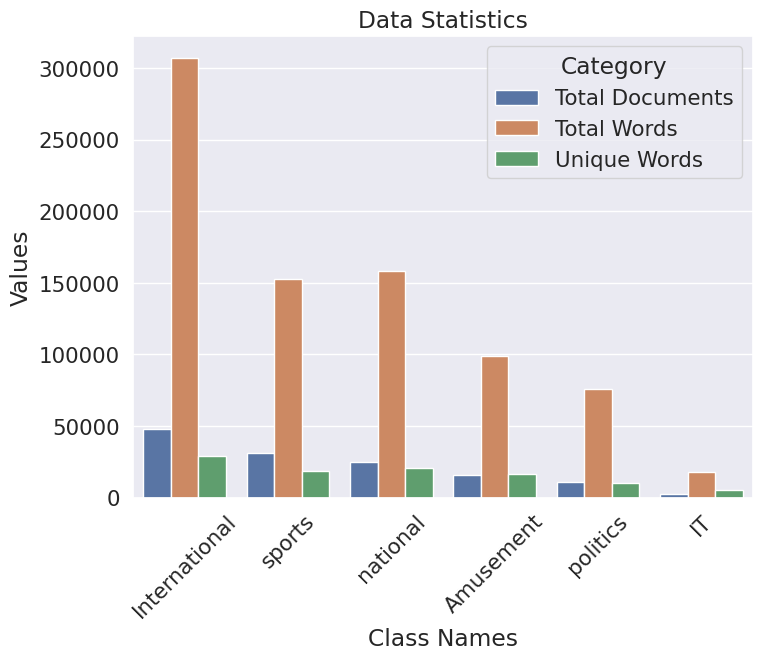

In [ ]:

data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

## Plotting thee frequency distribution.

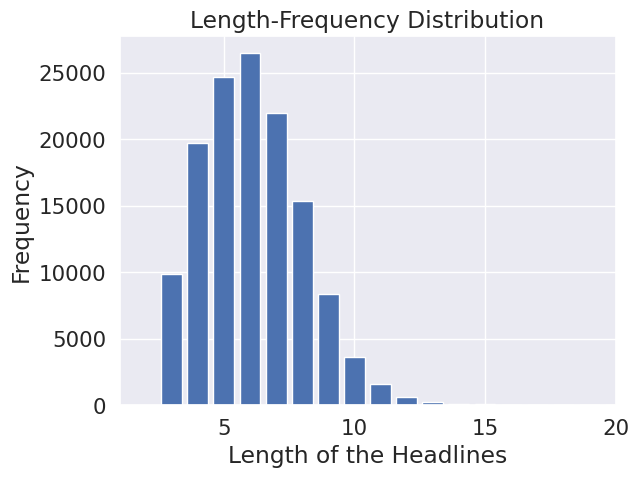

Maximum Length of a headline: 21
Minimum Length of a headline: 3
Average Length of a headline: 6.0


In [ ]:
# Calculate the Review of each of the Review
dataset['HeadlineLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.HeadlineLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a headline: {max(dataset.HeadlineLength)}")
print(f"Minimum Length of a headline: {min(dataset.HeadlineLength)}")
print(f"Average Length of a headline: {round(np.mean(dataset.HeadlineLength),0)}")

## Label encoding and Dataset splitting in Training and Testing set.

In [ ]:
def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        category: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(category[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #===========================================================

def dataset_split(headlines,category):


    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))

    return X_train,X_valid,X_test,y_train,y_valid,y_test

##Showing the Label Encoding result.

In [ ]:
labels = label_encoding(dataset.category,True)



			===== Label Encoding ===== 
Class Names:--> ['Amusement' 'IT' 'International' 'national' 'politics' 'sports']
Amusement   0 

IT   1 

politics   4 

International   2 

sports   5 

sports   5 

sports   5 

International   2 

national   3 

International   2 

International   2 

International   2 

International   2 

International   2 

Amusement   0 



## Splitting data dataset into Training Testind and Validation set.

In [ ]:

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.headline,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 132713 
	Training		 95552 
	Test			 13272 
	Validation		 23889


## Determine the vocab size , embedding dimension, lenght, truncation, padding and oov_token.

In [ ]:
vocab_size = 57000
embedding_dim = 64
max_length = 12
trunc_type='post'
padding_type='post'
oov_tok = ""

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(original,"\n",encoded)
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)

## Tokenizing the Training Data

In [ ]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

## Details of tokenization.

In [ ]:
 #============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 4125
নিয়ে 	 3213
ও 	 3201
নিহত 	 2683
নতুন 	 2288
হবে 	 2193
থেকে 	 2165
বাংলাদেশ 	 1741
সঙ্গে 	 1692
করে 	 1510

Words --> Documents:
না 	 4031
নিয়ে 	 3204
ও 	 3173
নিহত 	 2681
নতুন 	 2273
হবে 	 2182
থেকে 	 2162
বাংলাদেশ 	 1737
সঙ্গে 	 1684
করে 	 1499

Words --> Index:
মিসিসিপিতে 	 55055
ইয়ামেনি 	 55054
ওকিনাওয়ায় 	 55053
শনাক্তকরণের 	 55052
আবিষ্কৃত 	 55051
বেলজীয় 	 55050
পুজদেমনকে 	 55049
‘গান’ 	 55048
বেস 	 55047
ইনস্ট্রুমেন্টাল 	 55046

Total Documents --> 95552
Found 55055 unique tokens


## Padded Sequence

In [ ]:
padded_headlines(X_train[120],train_sequences[120],train_padded[120])


			====== Encoded Sequences ====== 

অসুস্থ হয়ে ফের হাসপাতালে দিলীপ কুমার 
 [477, 350, 2638, 1194]

			====== Paded Sequences ======
 অসুস্থ হয়ে ফের হাসপাতালে দিলীপ কুমার 
 [ 477  350 2638 1194    0    0    0    0    0    0    0    0]


## Validation Data Tokenization

In [ ]:

# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_valid[61569],validation_sequences[1],validation_padded[1])


			====== Encoded Sequences ====== 

জেলবন্দি তামিলদের মুক্তি দিতে পারেন রাজাপক্ষে 
 [1, 1410, 161, 18585, 4123, 2124, 2521, 2, 851]

			====== Paded Sequences ======
 জেলবন্দি তামিলদের মুক্তি দিতে পারেন রাজাপক্ষে 
 [    1  1410   161 18585  4123  2124  2521     2   851     0     0     0]


## Test data tokenization.

In [ ]:

# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_test[100],test_sequences[100],test_padded[100])


			====== Encoded Sequences ====== 

দেখতে পারেন শ্রীদেবীর সেরা ৪ ছবি (ভিডিও) 
 [822, 466, 778, 54443]

			====== Paded Sequences ======
 দেখতে পারেন শ্রীদেবীর সেরা ৪ ছবি (ভিডিও) 
 [  822   466   778 54443     0     0     0     0     0     0     0     0]


In [ ]:

# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

## Getting the GRU model ready with layers and callback function.

In [ ]:

keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 57000
embedding_dim = 64
max_length = 12
num_category = 6

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint]
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 64)            3648000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 3,701,166
Trainable params: 3,701,166
Non-trainable params: 0
______________________________________________

## Training the model.

In [ ]:

num_epochs = 10
batch = 64
history = model.fit(train_padded, train_label_seq,
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq),
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/10
1493/1493 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7480
Epoch 1: val_accuracy improved from -inf to 0.82745, saving model to /content/drive/MyDrive/data/data.csvModel.h5
1493/1493 [==============================] - 115s 73ms/step - loss: 0.6873 - accuracy: 0.7480 - val_loss: 0.4905 - val_accuracy: 0.8275
Epoch 2/10
1493/1493 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8812
Epoch 2: val_accuracy improved from 0.82745 to 0.83888, saving model to /content/drive/MyDrive/data/data.csvModel.h5
1493/1493 [==============================] - 109s 73ms/step - loss: 0.3375 - accuracy: 0.8812 - val_loss: 0.4631 - val_accuracy: 0.8389
Epoch 3/10
1493/1493 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9254
Epoch 3: val_accuracy improved from 0.83888 to 0.83909, saving model to /content/drive/MyDrive/data/data.csvModel.h5
1493/1493 [==============================] - 107s 72ms/step - loss: 0.2117 - accuracy:

## Saving the model and show result in Confusion Matrix

415/415 [==============================] - 4s 7ms/step


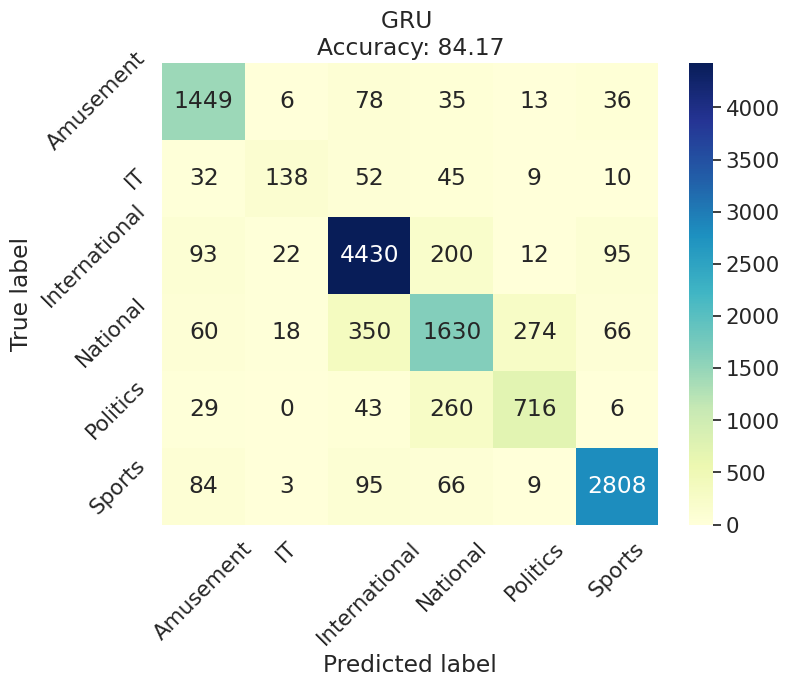

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import save_model
# load the Saved model from directory
model = load_model(path+"Model.h5")


predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,

                     index = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'],
                     columns = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [ ]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'National','4':'Politics','5':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Amusement,82.94,89.61,86.15,1617.000000
IT,73.80,48.25,58.35,286.000000
International,87.76,91.30,89.49,4852.000000
National,72.90,67.97,70.35,2398.000000
Politics,69.31,67.93,68.62,1054.000000
Sports,92.95,91.62,92.28,3065.000000
accuracy,84.17,84.17,84.17,0.841697
macro avg,79.94,76.11,77.54,13272.000000
weighted avg,83.92,84.17,83.94,13272.000000


In [ ]:
model = load_model(path+"Model.h5")


In [ ]:

# Import numpy
import numpy as np

# Define a new input as a string
new_input = 'মেক্সিকো সীমান্তে সেনা পাঠাচ্ছেন ট্রাম্প '

# Tokenize and pad the new input using the same tokenizer and pad_sequences functions
new_sequence = tokenizer.texts_to_sequences([new_input])
new_padded = pad_sequences(new_sequence, maxlen=12)

# Feed the padded sequence to the GRU model and get the prediction output
prediction = model.predict(new_padded)
print(prediction)
# Output: [[0.01 0.02 0.03 0.9  0.02 0.02]]

# Find the index of the maximum value in the output vector
predicted_category = np.argmax(prediction)
print(predicted_category)
# Output: 3

1/1 [==============================] - 1s 814ms/step
[[5.7923229e-04 3.9831657e-04 9.9515885e-01 1.9385335e-03 9.5660682e-05
  1.8294024e-03]]
2


In [ ]:
def get_category_from_number(number):
    category_mapping = {
        0: "Amusement",
        1: "IT",
        2: "International",
        3: "National",
        4: "Politics",
        5: "Sports"
    }

    return category_mapping.get(number, "Unknown")

# Example usage with your model's predicted number
predicted_number = predicted_category  # Replace with your model's predicted number
predicted_class = get_category_from_number(predicted_number)

print(f"Predicted Category: {predicted_class}")


Predicted Category: International


## Testing with Unseen Data

In [ ]:
# Import numpy
import numpy as np

# Define a new input as a string
new_input = str(input())

# Tokenize and pad the new input using the same tokenizer and pad_sequences functions
new_sequence = tokenizer.texts_to_sequences([new_input])
new_padded = pad_sequences(new_sequence, maxlen=12)

# Feed the padded sequence to the GRU model and get the prediction output
prediction = model.predict(new_padded)
#print(prediction)
# Output: [[0.01 0.02 0.03 0.9  0.02 0.02]]

# Find the index of the maximum value in the output vector
predicted_category = np.argmax(prediction)
print(predicted_category)
# Output: 3



def get_category_from_number(number):
    category_mapping = {
        0: "Amusement",
        1: "IT",
        2: "International",
        3: "National",
        4: "Politics",
        5: "Sports"
    }

    return category_mapping.get(number, "Unknown")

# Example usage with your model's predicted number
predicted_number = predicted_category  # Replace with your model's predicted number
predicted_class = get_category_from_number(predicted_number)

print(f"Predicted Category: {predicted_class}")

ঢাকার ২ হাসপাতালে মৃত্যু শতক ছাড়াল 
1/1 [==============================] - 0s 25ms/step
3
Predicted Category: National
